In [2]:
# Install Sentence-Transformers (SBERT)
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 4.9 MB/s eta 0:00:00a 0:00:01


In [3]:
import time
import numpy as np
import os
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sentence_transformers import SentenceTransformer

# Start time
start_time = time.time()

# Initialize NLTK tools
nltk.download('stopwords')
nltk.download('wordnet')
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define text preprocessing functions
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    text = text.lower()  # Convert to lowercase
    words = text.split()  # Split into words
    words = [word for word in words if word not in stop_words]  # Remove stop words
    return ' '.join(words)

def normalize_text(text, method='lemmatization'):
    words = text.split()
    if method == 'stemming':
        words = [stemmer.stem(word) for word in words]
    elif method == 'lemmatization':
        words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

def preprocess_text(text, method='lemmatization'):
    text = clean_text(text)
    text = normalize_text(text, method)
    return text

# Load SBERT model
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Function to get SBERT embeddings
def get_sbert_embeddings(texts, batch_size=100):
    all_embeddings = []
    num_batches = len(texts) // batch_size + (1 if len(texts) % batch_size > 0 else 0)
    print(f"Total number of batches: {num_batches}")

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]

        # Generate embeddings
        batch_embeddings = sbert_model.encode(batch_texts, convert_to_tensor=True, show_progress_bar=True)
        all_embeddings.extend(batch_embeddings.cpu().numpy())

        # Print status update
        print(f"Processed batch {i // batch_size + 1}/{num_batches}")

    return np.array(all_embeddings)

# Function to visualize clusters using PCA
def visualize_clusters(embeddings, cluster_labels, title='Clusters Visualization'):
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=cluster_labels, palette='Set2', legend='full', s=100)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

# Function to show example texts from each cluster
def show_cluster_examples(df, cluster_labels, n_examples=3):
    df['cluster'] = cluster_labels
    for cluster_num in set(cluster_labels):
        print(f"\nCluster {cluster_num} examples:")
        examples = df[df['cluster'] == cluster_num].sample(n=n_examples, random_state=42)
        for i, row in examples.iterrows():
            print(f"- {row['text']}")

# Function to perform K-Means clustering and evaluate silhouette score
def perform_kmeans_clustering(embeddings, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)

    silhouette_avg = silhouette_score(embeddings, cluster_labels)
    print(f"K-Means clustering with {n_clusters} clusters: Silhouette Score = {silhouette_avg}")

    return cluster_labels, silhouette_avg, kmeans

# Function to perform DBSCAN clustering
def perform_dbscan_clustering(embeddings, eps=0.5, min_samples=3):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(embeddings)

    num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    print(f"DBSCAN clustering found {num_clusters} clusters")

    if num_clusters > 1:
        silhouette_avg = silhouette_score(embeddings, cluster_labels)
        print(f"DBSCAN clustering: Silhouette Score = {silhouette_avg}")
    else:
        silhouette_avg = None
        print("DBSCAN did not find enough clusters to compute silhouette score.")

    return cluster_labels, silhouette_avg, dbscan

# Function to check if embeddings already exist and load them
def load_embeddings(file_path):
    if os.path.exists(file_path):
        print(f"Loading pre-generated embeddings from {file_path}...")
        return np.load(file_path)
    else:
        print(f"Embeddings file {file_path} not found. Proceeding to generate embeddings.")
        return None

# Load the datasets
train_file_path = '/kaggle/input/llm-embaddings/train.parquet'
test_file_path = '/kaggle/input/llm-embaddings/test.parquet'

train_df = pd.read_parquet(train_file_path)
test_df = pd.read_parquet(test_file_path)

# Define file paths for saved embeddings
train_embeddings_path = '/kaggle/input/llm-embaddings/train_embeddings.npy'
test_embeddings_path = '/kaggle/input/llm-embaddings/test_embeddings.npy'

# Try to load train embeddings
train_embeddings = load_embeddings(train_embeddings_path)

if train_embeddings is None:  # If embeddings were not loaded, generate them
    # Process train text
    if 'text' in train_df.columns:
        train_df['processed_text'] = train_df['text'].apply(lambda x: preprocess_text(x, method='lemmatization'))
        processed_train_text = train_df['processed_text'].tolist()

        # Generate embeddings
        print("Generating embeddings for training data...")
        train_embeddings = get_sbert_embeddings(processed_train_text)

        # Save embeddings
        np.save(train_embeddings_path, train_embeddings)
        print(f"Training embeddings saved at {train_embeddings_path}.")
    else:
        print("No 'text' column found in the training dataset.")

# Try to load test embeddings
test_embeddings = load_embeddings(test_embeddings_path)

if test_embeddings is None:  # If embeddings were not loaded, generate them
    # Process test text
    if 'text' in test_df.columns:
        test_df['processed_text'] = test_df['text'].apply(lambda x: preprocess_text(x, method='lemmatization'))
        processed_test_text = test_df['processed_text'].tolist()

        # Generate embeddings
        print("Generating embeddings for test data...")
        test_embeddings = get_sbert_embeddings(processed_test_text)

        # Save embeddings
        np.save(test_embeddings_path, test_embeddings)
        print(f"Test embeddings saved at {test_embeddings_path}.")
    else:
        print("No 'text' column found in the test dataset.")

# Now you can proceed with clustering using the loaded embeddings
print(f"Train Embeddings Shape: {train_embeddings.shape}")
print(f"Test Embeddings Shape: {test_embeddings.shape}")


/opt/conda/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Loading pre-generated embeddings from /kaggle/input/llm-embaddings/train_embeddings.npy...
Loading pre-generated embeddings from /kaggle/input/llm-embaddings/test_embeddings.npy...
Train Embeddings Shape: (120000, 384)
Test Embeddings Shape: (7600, 384)


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K-Means clustering with 4 clusters: Silhouette Score = 0.027225539088249207


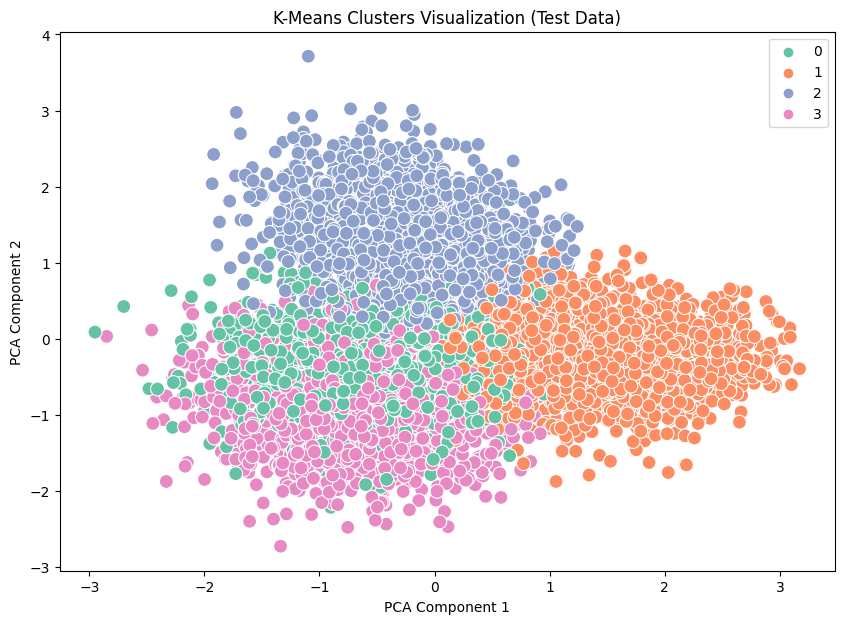

In [3]:
# Perform K-Means clustering on test data
kmeans_labels, kmeans_silhouette, kmeans_model = perform_kmeans_clustering(test_embeddings, n_clusters=4)

# Visualize K-Means clusters for test data
visualize_clusters(test_embeddings, kmeans_labels, title='K-Means Clusters Visualization (Test Data)')

DBSCAN clustering found 0 clusters
DBSCAN did not find enough clusters to compute silhouette score.


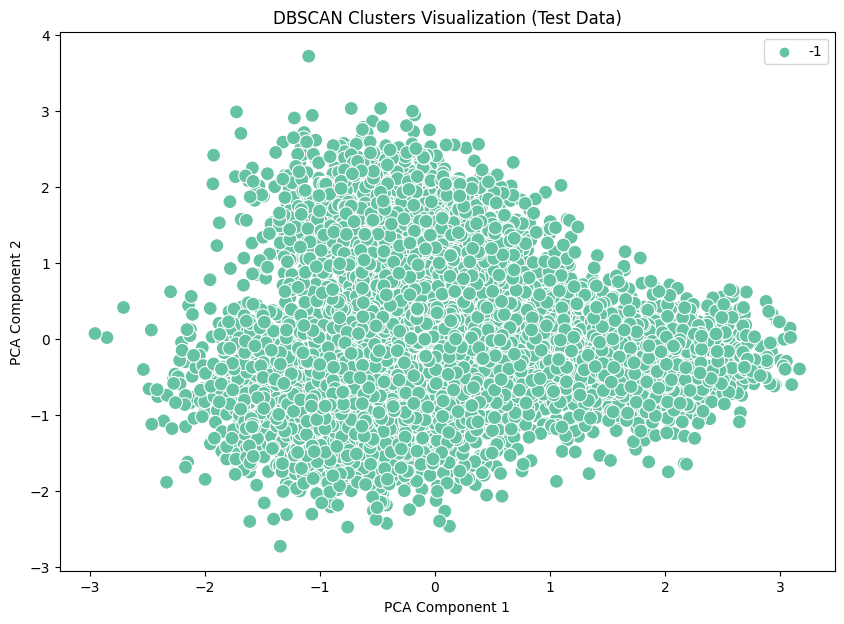

In [4]:
# Perform DBSCAN clustering on test data
dbscan_labels, dbscan_silhouette, dbscan_model = perform_dbscan_clustering(test_embeddings, eps=0.5, min_samples=5)

# Visualize DBSCAN clusters for test data
visualize_clusters(test_embeddings, dbscan_labels, title='DBSCAN Clusters Visualization (Test Data)')

In [5]:
# Show examples from K-Means clusters for test data
show_cluster_examples(test_df, kmeans_labels)

print("="*40)

# Show examples from DBSCAN clusters for test data
show_cluster_examples(test_df, dbscan_labels)


Cluster 0 examples:
- Court: Whales Have No Standing to Sue (AP) AP - A federal appeals court decided Wednesday that marine mammals have no standing to sue to stop the U.S. Navy from using sonar.
- Cingular to Cut About 7,000 Jobs (Reuters) Reuters - Cingular Wireless will cut about 7,000\jobs, or 10 percent of its work force, to cut costs as it\integrates recently purchased AT T Wireless, the company said\on Tuesday.
- Insurance firms can take hit Florida insurance companies can cover the losses of Hurricanes Charley and Frances, even if a few small insurers fail, the state #39;s chief financial officer said Tuesday.

Cluster 1 examples:
- Dutch security reviewed on threat THE HAGUE, Netherlands - The government vowed tough measures yesterday against what a leading politician called  quot;the arrival of jihad in the Netherlands quot; after a death threat to a Dutch lawmaker was found pinned with a knife to the body of a slain 
- Hurricane loss 'less than feared' Hurricane Frances cou

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K-Means clustering with 4 clusters: Silhouette Score = 0.028262753039598465


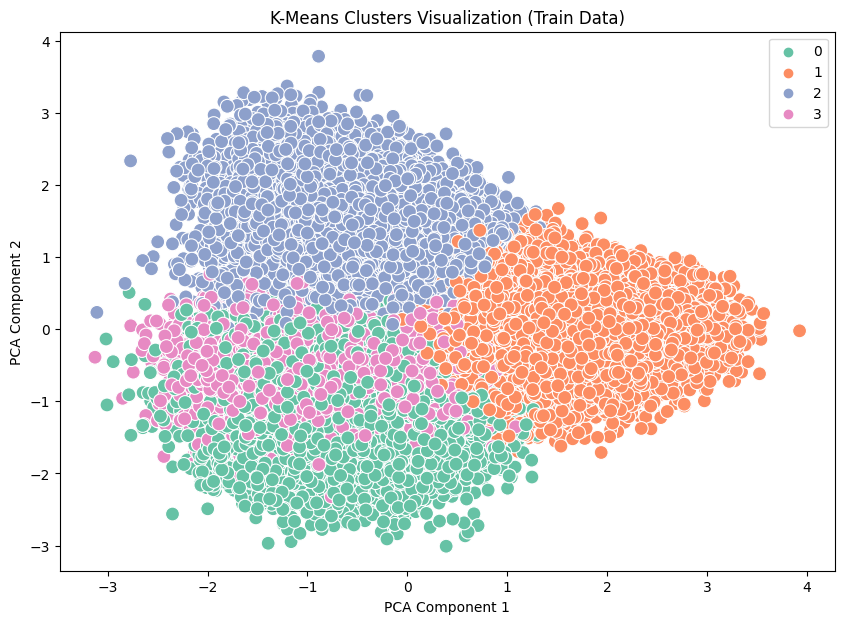

In [6]:
# Perform K-Means clustering on train data
kmeans_labels, kmeans_silhouette, kmeans_model = perform_kmeans_clustering(train_embeddings, n_clusters=4)

# Visualize K-Means clusters for train data
visualize_clusters(train_embeddings, kmeans_labels, title='K-Means Clusters Visualization (Train Data)')

DBSCAN clustering found 2 clusters
DBSCAN clustering: Silhouette Score = 0.017896147444844246


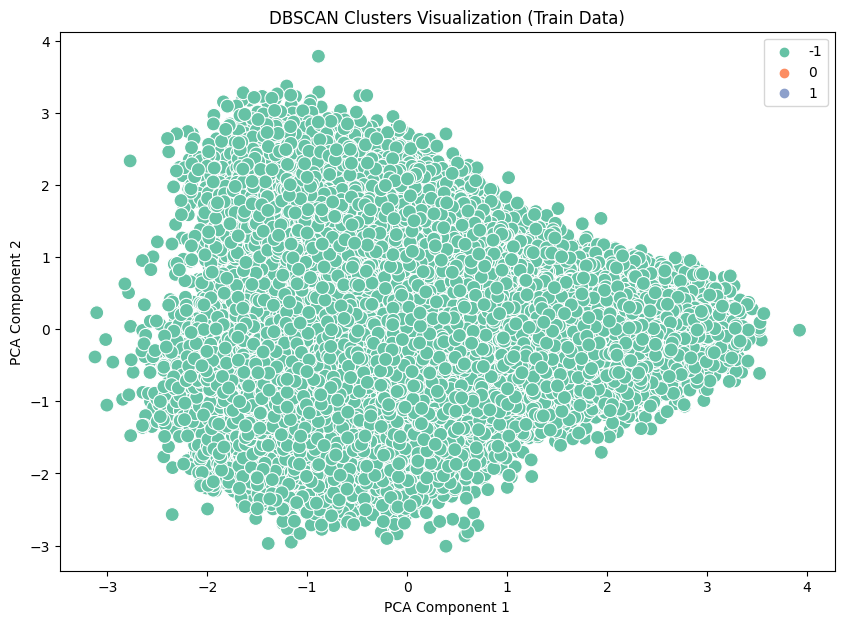

In [7]:
# Perform DBSCAN clustering on train data
dbscan_labels, dbscan_silhouette, dbscan_model = perform_dbscan_clustering(train_embeddings, eps=0.5, min_samples=5)

# Visualize DBSCAN clusters for train data
visualize_clusters(train_embeddings, dbscan_labels, title='DBSCAN Clusters Visualization (Train Data)')

In [8]:
# Show examples from K-Means clusters for train data
show_cluster_examples(train_df, kmeans_labels)

# Show examples from DBSCAN clusters for train data
show_cluster_examples(train_df, dbscan_labels)


Cluster 0 examples:
- Microsoft and Cisco team up on security Their biggest clients hit hard by viruses, worms and other attacks, Microsoft Corp. and Cisco Systems Inc. are planning to work together to help their corporate customers fight back.
- IBM seeks to ease database burden "Stinger" update of DB2 will focus on automatic administration and an improvement in clustered performance.
- Senate committee approves wireless spectrum bill The Senate Commerce, Science and Transportation Committee approved a bill that sets a 2008 deadline for clearing broadcasters from wireless spectrum promised to public safety agencies.

Cluster 1 examples:
- 3 hostages killed in Iraq, tape shows BAGHDAD - A militant Islamic group has killed three hostages in Iraq, a video posted on its website shows. The three men, identified as members of an Iraqi Kurdish group, were killed for helping the Americans, a statement accompanying the tape said.
- Mars rovers roll on with new funding NASA has agreed to fund 

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 4, Silhouette Score: 0.02646554261445999


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 5, Silhouette Score: 0.026036396622657776


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 6, Silhouette Score: 0.026440145447850227


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 7, Silhouette Score: 0.02561899460852146
Optimal number of clusters: 4


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K-Means clustering with 4 clusters: Silhouette Score = 0.02646554261445999


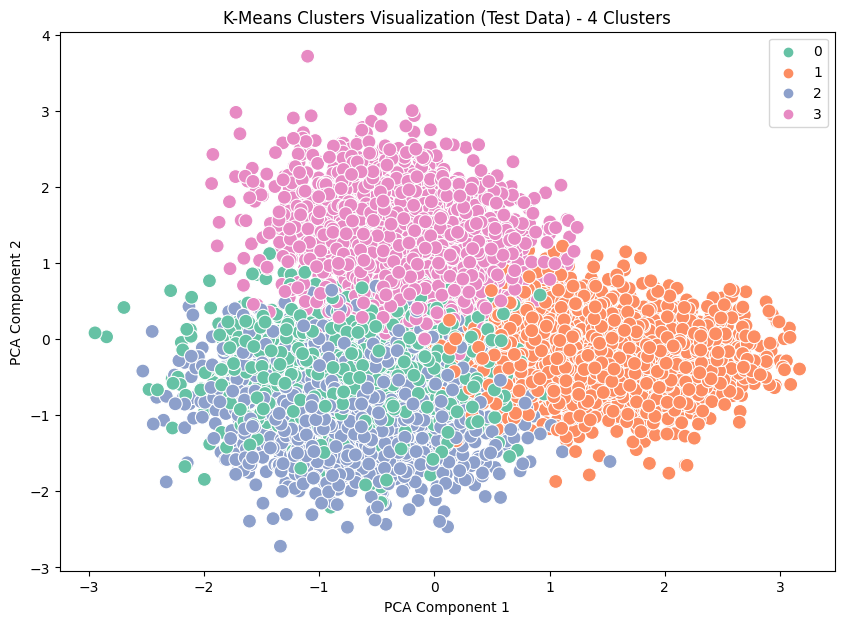


Cluster 0 examples:
- Rate hikes by Fed dull ARMs #39; luster 30-year fixed home loans remain appealing, but variable rates have been on the move up. By Sandra Block. If you #39;re hoping an adjustable-rate mortgage will help you afford your dream house, you may want to rethink those granite countertops.
- Avon Third-Quarter Profit Rises  CHICAGO (Reuters) - Avon Products Inc. &lt;A HREF="http://www.investor.reuters.com/FullQuote.aspx?ticker=AVP.N target=/stocks/quickinfo/fullquote"&gt;AVP.N&lt;/A&gt; on Friday  posted higher quarterly earnings as business in Latin America  and Europe helped offset weakness in the United States for the  direct seller of cosmetics.
- AMD's Q3 led by strong Opteron, Athlon 64 sales SAN FRANCISCO - As expected, Advanced Micro Devices Inc.'s (AMD's) third-quarter revenue came in a little under the company's earlier predictions, but strong increases in sales of its 64-bit desktop and server processors led to the company's fourth straight profitable quarter

In [9]:
# Function to perform K-Means clustering and find the optimal number of clusters
def perform_kmeans_clustering_with_optimal_clusters(embeddings, cluster_range=(4, 8)):
    # Step 1: Scale the embeddings (K-Means performs better with scaled data)
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings)

    # Step 2: Determine the optimal number of clusters using silhouette score
    silhouette_scores = []
    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(embeddings_scaled)
        score = silhouette_score(embeddings_scaled, cluster_labels)
        silhouette_scores.append(score)
        print(f'Number of clusters: {n_clusters}, Silhouette Score: {score}')

    # Step 3: Find the optimal number of clusters (highest silhouette score)
    optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
    print(f'Optimal number of clusters: {optimal_clusters}')

    # Step 4: Perform K-Means clustering using the optimal number of clusters
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    optimal_cluster_labels = kmeans.fit_predict(embeddings_scaled)

    silhouette_avg = silhouette_score(embeddings_scaled, optimal_cluster_labels)
    print(f"K-Means clustering with {optimal_clusters} clusters: Silhouette Score = {silhouette_avg}")

    return optimal_cluster_labels, silhouette_avg, kmeans, optimal_clusters

# Perform K-Means clustering with optimal number of clusters for the test data
kmeans_labels_test, kmeans_silhouette_test, kmeans_model_test, optimal_clusters_test = perform_kmeans_clustering_with_optimal_clusters(test_embeddings, cluster_range=range(4, 8))

# Visualize K-Means clusters for test data using the optimal number of clusters
visualize_clusters(test_embeddings, kmeans_labels_test, title=f'K-Means Clusters Visualization (Test Data) - {optimal_clusters_test} Clusters')

# Show examples from K-Means clusters for test data
show_cluster_examples(test_df, kmeans_labels_test)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 4, Silhouette Score: 0.02726306952536106


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 5, Silhouette Score: 0.02733733505010605


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 6, Silhouette Score: 0.026595739647746086


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 7, Silhouette Score: 0.026722189038991928
Optimal number of clusters: 5


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K-Means clustering with 5 clusters: Silhouette Score = 0.02733733505010605


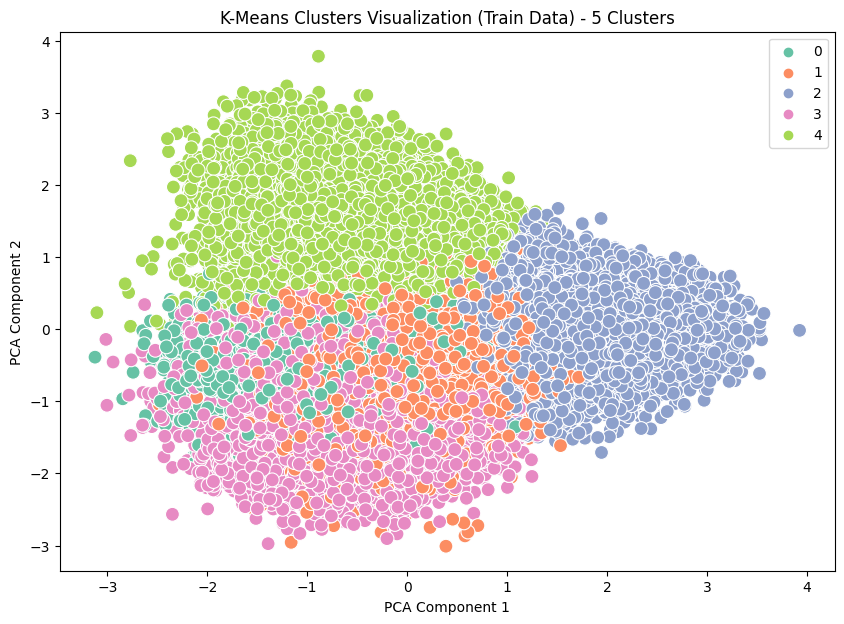


Cluster 0 examples:
- General Mills Profit Down 19 Percent  LOS ANGELES (Reuters) - General Mills Inc. on Tuesday  reported a steeper-than-expected drop in quarterly net income  due to higher food ingredient costs and stepped-up spending on  promotions.
- Pulitzer Inc. says it #39;s considering sale ST. LOUIS - Pulitzer Inc. said Sunday that company officials are considering selling the newspaper publisher to boost shareholder value.
- Soft Demand for TFTs Affects Prices TFT LCD panel prices are expected to fall significantly for larger area 17 inch and 19 inch panels for LCD TVs, but the cost of products in the shops is still seen as a barrier to high volume consumer demand, according to ...

Cluster 1 examples:
- Clippers excercise option on Wilcox LOS ANGELES (Ticker) - As expected, the Los Angeles Clippers on Monday exercised the 2005-06 contract option on forward Chris Wilcox.
- Battle on Secret Evidence in Jackson Case SANTA MARIA, Calif. - In a high-stakes drama of legal gamesm

In [10]:
# Perform K-Means clustering with optimal number of clusters for the train data
kmeans_labels_train, kmeans_silhouette_train, kmeans_model_train, optimal_clusters_train = perform_kmeans_clustering_with_optimal_clusters(train_embeddings, cluster_range=range(4, 8))

# Visualize K-Means clusters for train data using the optimal number of clusters
visualize_clusters(train_embeddings, kmeans_labels_train, title=f'K-Means Clusters Visualization (Train Data) - {optimal_clusters_train} Clusters')

# Show examples from K-Means clusters for train data
show_cluster_examples(train_df, kmeans_labels_train)

In [6]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import itertools

def perform_dbscan_clustering_with_optimal_params(embeddings, eps_range=(0.3, 0.6, 0.1), min_samples_range=(4, 6, 1)):
    # Step 1: Scale the embeddings (DBSCAN often performs better on scaled data)
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings)

    best_eps = None
    best_min_samples = None
    best_silhouette_score = -1
    best_dbscan = None
    best_labels = None

    # Generate all combinations of eps and min_samples
    eps_values = np.arange(eps_range[0], eps_range[1], eps_range[2])
    min_samples_values = np.arange(min_samples_range[0], min_samples_range[1], min_samples_range[2])

    for eps, min_samples in itertools.product(eps_values, min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(embeddings_scaled)

        # Skip if only one cluster is found or if all points are labeled as noise
        if len(set(cluster_labels)) <= 1 or len(set(cluster_labels)) == 1 and list(set(cluster_labels))[0] == -1:
            continue

        # Compute silhouette score
        score = silhouette_score(embeddings_scaled, cluster_labels)
        print(f'eps: {eps}, min_samples: {min_samples}, Silhouette Score: {score}')

        if score > best_silhouette_score:
            best_eps = eps
            best_min_samples = min_samples
            best_silhouette_score = score
            best_dbscan = dbscan
            best_labels = cluster_labels

    if best_labels is None:
        print('No valid clusters found.')
    else:
        print(f'Optimal eps: {best_eps}, Optimal min_samples: {best_min_samples}')
        print(f'Best Silhouette Score: {best_silhouette_score}')

    return best_labels, best_silhouette_score, best_dbscan, best_eps, best_min_samples

def show_cluster_examples(df, cluster_labels, n_examples=3):
    if cluster_labels is None or len(set(cluster_labels)) == 1 and list(set(cluster_labels))[0] == -1:
        print("No valid clusters to show examples.")
        return

    df['cluster'] = cluster_labels
    for cluster_num in set(cluster_labels):
        print(f"\nCluster {cluster_num} examples:")
        examples = df[df['cluster'] == cluster_num].sample(n=n_examples, random_state=42)
        print(examples)


In [ ]:
def show_cluster_examples(df, cluster_labels, n_examples=3):
    if cluster_labels is None or len(set(cluster_labels)) == 1 and list(set(cluster_labels))[0] == -1:
        print("No valid clusters to show examples.")
        return

    df['cluster'] = cluster_labels
    for cluster_num in set(cluster_labels):
        print(f"\nCluster {cluster_num} examples:")
        examples = df[df['cluster'] == cluster_num].sample(n=n_examples, random_state=42)
        print(examples)


No valid clusters found.


/tmp/ipykernel_82/715429724.py:75: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=cluster_labels, palette='Set2', legend='full', s=100)


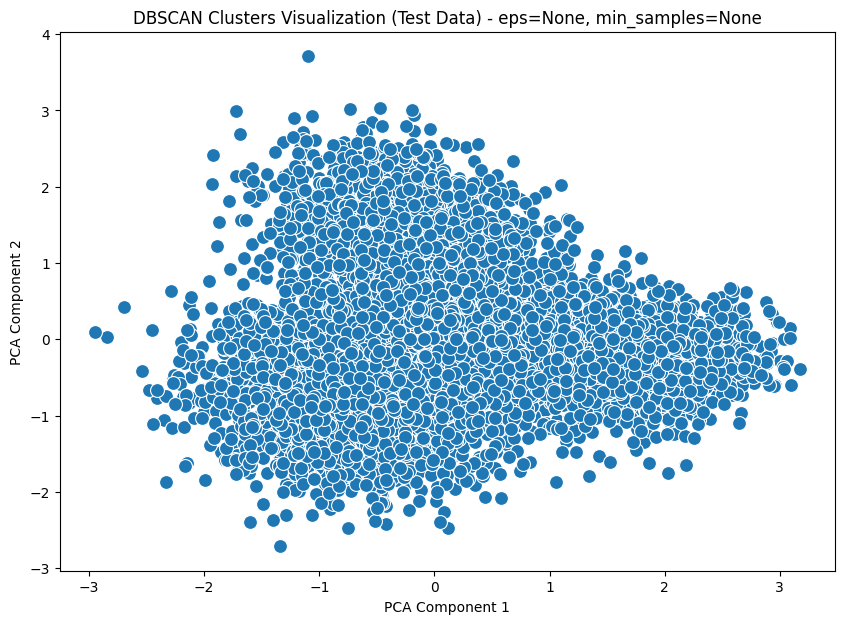

No valid clusters to show examples.


In [16]:

# Perform DBSCAN clustering with optimal hyperparameters for the test data
dbscan_labels_test, dbscan_silhouette_test, dbscan_model_test, optimal_eps_test, optimal_min_samples_test = perform_dbscan_clustering_with_optimal_params(test_embeddings, eps_range=(0.3, 0.6, 0.1), min_samples_range=(3, 10, 1))

# Visualize DBSCAN clusters for test data using the optimal parameters
visualize_clusters(test_embeddings, dbscan_labels_test, title=f'DBSCAN Clusters Visualization (Test Data) - eps={optimal_eps_test}, min_samples={optimal_min_samples_test}')

# Show examples from DBSCAN clusters for test data
show_cluster_examples(test_df, dbscan_labels_test)

eps: 0.3, min_samples: 3, Silhouette Score: -0.08143975585699081
eps: 0.3, min_samples: 4, Silhouette Score: 0.015309629030525684
eps: 0.3, min_samples: 5, Silhouette Score: 0.020236169919371605
eps: 0.3, min_samples: 6, Silhouette Score: 0.06522422283887863
eps: 0.3, min_samples: 7, Silhouette Score: 0.06522422283887863
eps: 0.3, min_samples: 8, Silhouette Score: 0.06522422283887863
eps: 0.4, min_samples: 3, Silhouette Score: -0.08143975585699081
eps: 0.4, min_samples: 4, Silhouette Score: 0.015309629030525684
eps: 0.4, min_samples: 5, Silhouette Score: 0.020236169919371605
eps: 0.4, min_samples: 6, Silhouette Score: 0.06522422283887863
eps: 0.4, min_samples: 7, Silhouette Score: 0.06522422283887863
eps: 0.4, min_samples: 8, Silhouette Score: 0.06522422283887863
eps: 0.5, min_samples: 3, Silhouette Score: -0.08143975585699081
eps: 0.5, min_samples: 4, Silhouette Score: 0.015309629030525684
eps: 0.5, min_samples: 5, Silhouette Score: 0.020236169919371605
eps: 0.5, min_samples: 6, Silho

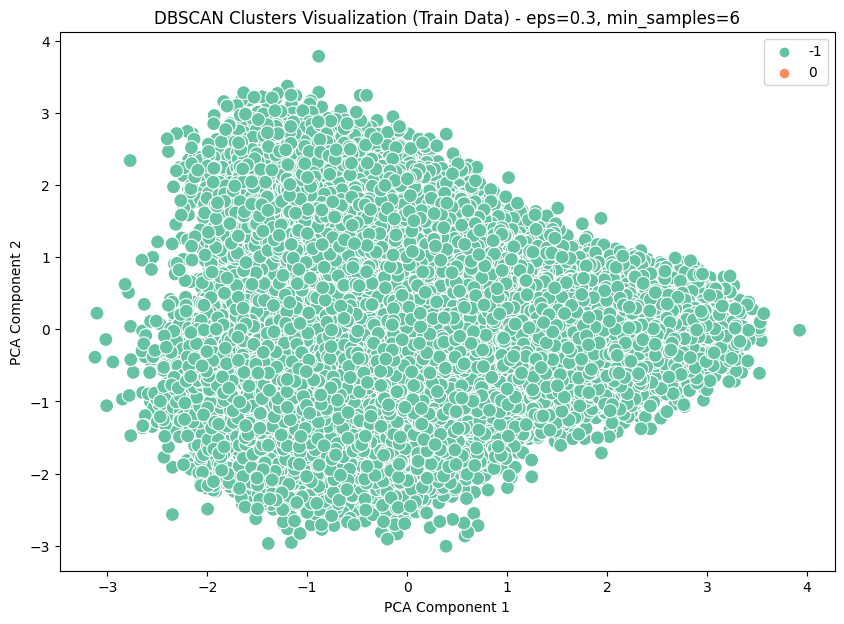


Cluster 0 examples:
                                                    text  label  cluster
53797  Photo 3 of 8: Global gamers clash for cash \$2...      3        0
53801  Photo 6 of 8: Global gamers clash for cash \$2...      3        0
53738  Photo 1 of 8: Global gamers clash for cash \$2...      3        0

Cluster -1 examples:
                                                    text  label  cluster
77648  Black quitting posts at Hollinger Inc. TORONTO...      2       -1
60470  IBM, Cisco aim to protect networks The compani...      3       -1
39160  Website claims hostage is dead A POSTING on an...      0       -1


In [8]:
# Perform DBSCAN clustering with optimal hyperparameters for the train data
dbscan_labels_train, dbscan_silhouette_train, dbscan_model_train, optimal_eps_train, optimal_min_samples_train = perform_dbscan_clustering_with_optimal_params(train_embeddings, eps_range=(0.3, 0.6, 0.1), min_samples_range=(3, 10, 1))

# Visualize DBSCAN clusters for train data using the optimal parameters
visualize_clusters(train_embeddings, dbscan_labels_train, title=f'DBSCAN Clusters Visualization (Train Data) - eps={optimal_eps_train}, min_samples={optimal_min_samples_train}')

# Show examples from DBSCAN clusters for train data
show_cluster_examples(train_df, dbscan_labels_train)

In [9]:
# End time
end_time = time.time()
execution_time = end_time - start_time
final_time = execution_time / 60
print(f"Total execution time: {final_time} minutes")

Total execution time: 145.14446113904316 minutes


In [7]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import itertools

def perform_dbscan_clustering_with_optimal_params(embeddings, eps_range=0.3, min_samples_range=(10, 12, 1)):
    # Step 1: Scale the embeddings (DBSCAN often performs better on scaled data)
    scaler = StandardScaler()
    embeddings_scaled = scaler.fit_transform(embeddings)

    best_eps = None
    best_min_samples = None
    best_silhouette_score = -1
    best_dbscan = None
    best_labels = None

    # Generate all combinations of eps and min_samples
    eps_values = np.arange(eps_range[0], eps_range[1], eps_range[2])
    min_samples_values = np.arange(min_samples_range[0], min_samples_range[1], min_samples_range[2])

    for eps, min_samples in itertools.product(eps_values, min_samples_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        cluster_labels = dbscan.fit_predict(embeddings_scaled)

        # Skip if only one cluster is found or if all points are labeled as noise
        if len(set(cluster_labels)) <= 1 or len(set(cluster_labels)) == 1 and list(set(cluster_labels))[0] == -1:
            continue

        # Compute silhouette score
        score = silhouette_score(embeddings_scaled, cluster_labels)
        print(f'eps: {eps}, min_samples: {min_samples}, Silhouette Score: {score}')

        if score > best_silhouette_score:
            best_eps = eps
            best_min_samples = min_samples
            best_silhouette_score = score
            best_dbscan = dbscan
            best_labels = cluster_labels

    if best_labels is None:
        print('No valid clusters found.')
    else:
        print(f'Optimal eps: {best_eps}, Optimal min_samples: {best_min_samples}')
        print(f'Best Silhouette Score: {best_silhouette_score}')

    return best_labels, best_silhouette_score, best_dbscan, best_eps, best_min_samples


def show_cluster_examples(df, cluster_labels, n_examples=3):
    if cluster_labels is None or len(set(cluster_labels)) == 1 and list(set(cluster_labels))[0] == -1:
        print("No valid clusters to show examples.")
        return

    df['cluster'] = cluster_labels
    for cluster_num in set(cluster_labels):
        print(f"\nCluster {cluster_num} examples:")
        examples = df[df['cluster'] == cluster_num].sample(n=n_examples, random_state=42)
        print(examples)


No valid clusters found.


/tmp/ipykernel_36/715429724.py:75: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=cluster_labels, palette='Set2', legend='full', s=100)


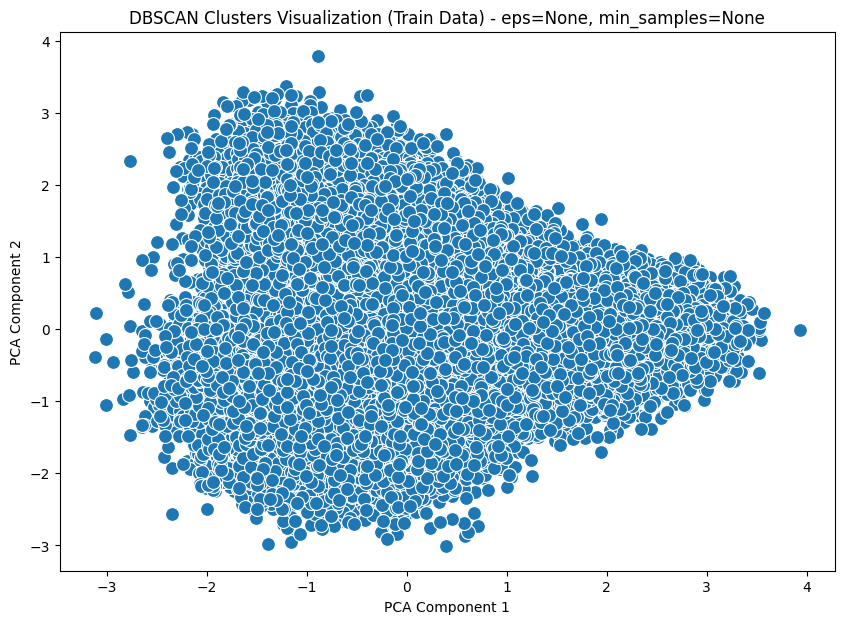

No valid clusters to show examples.


In [8]:
# Perform DBSCAN clustering with optimal hyperparameters for the train data
dbscan_labels_train, dbscan_silhouette_train, dbscan_model_train, optimal_eps_train, optimal_min_samples_train = perform_dbscan_clustering_with_optimal_params(train_embeddings, eps_range=(0.5,0.7,0.1), min_samples_range=(9, 12, 1))

# Visualize DBSCAN clusters for train data using the optimal parameters
visualize_clusters(train_embeddings, dbscan_labels_train, title=f'DBSCAN Clusters Visualization (Train Data) - eps={optimal_eps_train}, min_samples={optimal_min_samples_train}')

# Show examples from DBSCAN clusters for train data
show_cluster_examples(train_df, dbscan_labels_train)

In [ ]:
# import time
# # Start time
# start_time = time.time()

# # Import necessary libraries
# import numpy as np
# import pandas as pd
# from sklearn.cluster import KMeans
# from sklearn.metrics.cluster import adjusted_rand_score
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# import torch
# import re
# import nltk
# from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer, WordNetLemmatizer
# from sklearn.cluster import KMeans, DBSCAN
# from sklearn.metrics import silhouette_score
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sentence_transformers import SentenceTransformer
# # from tqdm.autonotebook import tqdm

# # Load the datasets
# train_file_path = '/content/train.parquet'
# test_file_path = '/content/test.parquet'

# # Load the datasets
# train_df = pd.read_parquet(train_file_path)
# test_df = pd.read_parquet(test_file_path)

# # Display the first few rows to understand the structure
# print(train_df.head())
# print(test_df.head())
# # Initialize NLTK tools
# nltk.download('stopwords')
# nltk.download('wordnet')
# stemmer = PorterStemmer()
# lemmatizer = WordNetLemmatizer()
# stop_words = set(stopwords.words('english'))
# # Define text preprocessing functions
# def clean_text(text):
#     text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
#     text = text.lower()  # Convert to lowercase
#     words = text.split()  # Split into words
#     words = [word for word in words if word not in stop_words]  # Remove stop words
#     return ' '.join(words)

# def normalize_text(text, method='lemmatization'):
#     words = text.split()
#     if method == 'stemming':
#         words = [stemmer.stem(word) for word in words]
#     elif method == 'lemmatization':
#         words = [lemmatizer.lemmatize(word) for word in words]
#     return ' '.join(words)

# def preprocess_text(text, method='lemmatization'):
#     text = clean_text(text)
#     text = normalize_text(text, method)
#     return text

# # Apply preprocessing to the train and test data
# if 'text' in train_df.columns:
#     train_df['processed_text'] = train_df['text'].apply(lambda x: preprocess_text(x, method='lemmatization'))
# else:
#     print("Column 'text' not found in training data.")

# processed_train_text = train_df['processed_text'].tolist() if 'processed_text' in train_df.columns else []

# # Load SBERT model
# sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# # Function to get SBERT embeddings
# def get_sbert_embeddings(texts, batch_size=100):
#     all_embeddings = []
#     num_batches = len(texts) // batch_size + (1 if len(texts) % batch_size > 0 else 0)

#     print(f"Total number of batches: {num_batches}")

#     for i in range(0, len(texts), batch_size):
#         batch_texts = texts[i:i+batch_size]

#         # Generate embeddings
#         batch_embeddings = sbert_model.encode(batch_texts, convert_to_tensor=True, show_progress_bar=True)
#         all_embeddings.extend(batch_embeddings.cpu().numpy())

#         # Print status update
#         print(f"Processed batch {i // batch_size + 1}/{num_batches}")

#     return np.array(all_embeddings)
# # Function to visualize clusters using PCA
# def visualize_clusters(embeddings, cluster_labels, title='Clusters Visualization'):
#     # Reduce dimensions with PCA to 2 components
#     pca = PCA(n_components=2)
#     reduced_embeddings = pca.fit_transform(embeddings)

#     # Create a scatter plot
#     plt.figure(figsize=(10, 7))
#     sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=cluster_labels, palette='Set2', legend='full', s=100)
#     plt.title(title)
#     plt.xlabel('PCA Component 1')
#     plt.ylabel('PCA Component 2')
#     plt.show()


# # Function to show example texts from each cluster
# def show_cluster_examples(df, cluster_labels, n_examples=3):
#     df['cluster'] = cluster_labels
#     for cluster_num in set(cluster_labels):
#         print(f"\nCluster {cluster_num} examples:")
#         examples = df[df['cluster'] == cluster_num].sample(n=n_examples, random_state=42)
#         for i, row in examples.iterrows():
#             print(f"- {row['text']}")
# # Function to perform K-Means clustering and evaluate silhouette score
# def perform_kmeans_clustering(embeddings, n_clusters=5):
#     kmeans = KMeans(n_clusters=n_clusters, random_state=42)
#     cluster_labels = kmeans.fit_predict(embeddings)

#     # Evaluate using silhouette score
#     silhouette_avg = silhouette_score(embeddings, cluster_labels)
#     print(f"K-Means clustering with {n_clusters} clusters: Silhouette Score = {silhouette_avg}")

#     return cluster_labels, silhouette_avg, kmeans

# # Function to perform DBSCAN clustering
# def perform_dbscan_clustering(embeddings, eps=0.5, min_samples=3):
#     dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#     cluster_labels = dbscan.fit_predict(embeddings)

#     # Check the number of unique clusters
#     num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
#     print(f"DBSCAN clustering found {num_clusters} clusters")

#     if num_clusters > 1:
#         silhouette_avg = silhouette_score(embeddings, cluster_labels)
#         print(f"DBSCAN clustering: Silhouette Score = {silhouette_avg}")
#     else:
#         silhouette_avg = None
#         print("DBSCAN did not find enough clusters to compute silhouette score.")

#     return cluster_labels, silhouette_avg, dbscan
# if 'text' in test_df.columns:
#     test_df['processed_text'] = test_df['text'].apply(lambda x: preprocess_text(x, method='lemmatization'))
# else:
#     print("Column 'text' not found in test data.")

# processed_test_text = test_df['processed_text'].tolist() if 'processed_text' in test_df.columns else []

# if processed_test_text:
#     print("Generating embeddings for test data...")
#     test_embeddings = get_sbert_embeddings(processed_test_text)
#     np.save('/content/test_embeddings.npy', test_embeddings)
#     print("Test embeddings saved.")
# else:
#     print("No processed test text available.")


# test_embeddings.shape
# # Perform K-Means clustering with an example number of clusters
# kmeans_labels, kmeans_silhouette, kmeans_model = perform_kmeans_clustering(test_embeddings, n_clusters=4)
# # Perform DBSCAN clustering with default parameters
# dbscan_labels, dbscan_silhouette, dbscan_model = perform_dbscan_clustering(test_embeddings, eps=0.5, min_samples=5)

# # Visualize the K-Means clusters
# visualize_clusters(test_embeddings, kmeans_labels, title='K-Means Clusters Visualization')

# # Visualize the DBSCAN clusters
# visualize_clusters(test_embeddings, dbscan_labels, title='DBSCAN Clusters Visualization')

# # Show examples from K-Means clusters
# show_cluster_examples(test_df, kmeans_labels)

# # Show examples from DBSCAN clusters
# show_cluster_examples(test_df, dbscan_labels)

# # Example usage
# if processed_train_text:
#     print("Generating embeddings for training data...")
#     train_embeddings = get_sbert_embeddings(processed_train_text)
#     np.save('/content/train_embeddings.npy', train_embeddings)
#     print("Training embeddings saved.")
# else:
#     print("No processed training text available.")

# # Check the shape of the embeddings
# train_embeddings.shape
# # Perform K-Means clustering with an example number of clusters
# kmeans_labels, kmeans_silhouette, kmeans_model = perform_kmeans_clustering(train_embeddings, n_clusters=4)
# # Visualize the K-Means clusters
# visualize_clusters(train_embeddings, kmeans_labels, title='K-Means Clusters Visualization')
# # Show examples from K-Means clusters
# show_cluster_examples(train_df, kmeans_labels)

# train_embeddings = train_embeddings[:]
# # Perform DBSCAN clustering with default parameters
# dbscan_labels, dbscan_silhouette, dbscan_model = perform_dbscan_clustering(train_embeddings, eps=1.5, min_samples=3)
# # Visualize the DBSCAN clusters
# visualize_clusters(train_embeddings, dbscan_labels, title='DBSCAN Clusters Visualization')
# # # Show examples from DBSCAN clusters
# # show_cluster_examples(train_df, dbscan_labels)
# # End time
# end_time = time.time()

# # Calculate and display runtime
# execution_time = end_time - start_time
# print(f"Execution Time: {execution_time} seconds")
# final time  = execution_time/60

# print("Total taken  time  is {}".format(final_time)("minutes")